
# Running Ensemble Inference

The following notebook demostrates how to use Earth-2 MIP's config schema and builtin
inference workflows to perform ensemmble inference of the FourCastNetv2 small (FCNv2-sm)
weather model with an intial state pulled from the Climate Data Store (CDS) and
perturbed with random noise. The ensemble output will then be loaded into an Xarray
Dataset and some sample data analysis is provided.

In summary this notebook will cover the following topics:

- Configuring and setting up FCNv2 model registry
- An ensemble configuration file
- Running ensemble inference in Earth-2 MIP to produce an xarray DataSet
- Post processing results


## Set Up
Starting off with imports, hopefully you have already installed Earth-2 MIP from this
repository. There are a few additional packages needed.



In [1]:
config = {
    "ensemble_members": 4,
    "noise_amplitude": 0.05,
    "simulation_length": 10,
    "weather_event": {
        "properties": {
            "name": "Globe",
            "start_time": "2017-08-23 12:00:00",
            #"start_time": "2022-07-01 00:00:00",
            "initial_condition_source": "era5",
        },
        "domains": [
            {
                "name": "global",
                "type": "Window",
                "diagnostics": [{"type": "raw", "channels": ["t2m", "u10m", "v10m", "u925", "v925"]}],
            }
        ],
    },
    "output_path": "outputs/01_ensemble_notebook",
    "output_frequency": 1,
    "weather_model": "fcnv2_sm",
    "seed": 12345,
    "use_cuda_graphs": False,
    "ensemble_batch_size": 1,
    "autocast_fp16": False,
    "perturbation_strategy": "correlated",
    "noise_reddening": 2.0,
}

In [2]:
import os
import xarray
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import numpy as np
import pandas as pd
from matplotlib.colors import TwoSlopeNorm

datafile = '/e2ws/exercises/harvey_10_days.nc'


countries = cfeature.NaturalEarthFeature(
    category="cultural",
    name="admin_0_countries",
    scale="50m",
    facecolor="none",
    edgecolor="black",
)

def open_ensemble(f, domain, chunks={"time": 1}):
    time = xarray.open_dataset(f).time
    root = xarray.open_dataset(f, decode_times=False)
    ds = xarray.open_dataset(f, chunks=chunks, group=domain)
    ds.attrs = root.attrs
    return ds.assign_coords(time=time)


output_path = config["output_path"]
domains = config["weather_event"]["domains"][0]["name"]
ensemble_members = config["ensemble_members"]
ds = open_ensemble(datafile, domains)
ds

<xarray.Dataset>
Dimensions:  (lat: 721, lon: 1440, ensemble: 4, time: 41)
Coordinates:
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * time     (time) datetime64[ns] 2017-08-23T12:00:00 ... 2017-09-02T12:00:00
Dimensions without coordinates: ensemble
Data variables:
    imin     int64 ...
    imax     int64 ...
    jmin     int64 ...
    jmax     int64 ...
    t2m      (ensemble, time, lat, lon) float64 dask.array<chunksize=(2, 1, 361, 720), meta=np.ndarray>
    u10m     (ensemble, time, lat, lon) float64 dask.array<chunksize=(2, 1, 361, 720), meta=np.ndarray>
    v10m     (ensemble, time, lat, lon) float64 dask.array<chunksize=(2, 1, 361, 720), meta=np.ndarray>
    u925     (ensemble, time, lat, lon) float64 dask.array<chunksize=(2, 1, 361, 720), meta=np.ndarray>
    v925     (ensemble, time, lat, lon) float64 dask.array<chunksize=(2, 1, 361, 720), meta=np.ndarray>
Attributes:
    model:          fcnv2_sm
    config:         {"weather_model": "fcnv2_sm", "simulation_length": 40, "p...
    weather_event:  {"properties": {"name": "Globe", "start_time": "2017-08-2...
    date_created:   2024-03-06T14:13:18.150697
    history:        /usr/local/lib/python3.10/dist-packages/ipykernel_launche...
    institution:    NVIDIA
    Conventions:    CF-1.10

## Post Processing
With inference complete, now the fun part: post processing and analysis!
You can manipulate the data to your hearts content now that its in an Xarray Dataset.
Here we will demonstrate some common plotting / analysis workflows one may be
interested. Lets start off with importing all our post processing packages.

(You may need to pip install matplotlib and cartopy)



Next, lets plot some fields of surface temperature. Since we have an ensemble of
predictions, lets display the first ensemble member, which is deterministic member,
and also the last ensemble member and the ensemmble standard deviation. One or both of
the perturbed members may look a little noisy, thats because our noise amplitude is
maybe too high. Try lowering the amplitude in the config or changing pertibation type
to see what happens.



In [28]:
# %matplotlib inline
plt.rcParams["animation.html"] = "jshtml"
time_str = 'lead time:'
projection=ccrs.PlateCarree()
var_ds = np.sqrt(np.square(ds.u10m) + np.square(ds.v10m))
min_val = 0
max_val = float(np.max(var_ds[0,:,:,:]))

scale = 2

# define plots
def make_figure():
    fig = plt.figure(figsize=(11,5))
    ax = fig.add_subplot(1, 1, 1, projection=projection)

    ax.add_feature(cfeature.COASTLINE,lw=.5)
    ax.add_feature(cfeature.RIVERS,lw=.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.6, edgecolor='dimgray')

    # ax.set_xticks(np.arange(0., 18., 2.5), crs=crs.PlateCarree())
    # ax.set_yticks(np.arange(43.5, 50.,1.5), crs=crs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=False)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    return fig, ax

def make_frame(frame):
    print(f'processing frame {frame+1} of {var_ds.shape[1]}')
    plot_ds = var_ds[0, max(frame,0), :, :]
    pc = ax.pcolormesh(ds.lon[::scale], ds.lat[::scale], plot_ds[::scale, ::scale], transform=projection,
                    cmap='plasma', vmin=min_val, vmax=max_val)

    if frame==-1:
        cbar = fig.colorbar(pc, extend='both', shrink=0.8, ax=ax)
        cbar.set_label('temperature [°C]', fontsize=12)

    header = time_str + " " + f'{frame}:00:00'
    ax.set_title(header, fontsize=14)

    return pc

def animate(frame):
    return make_frame(frame)

def first_frame():
    return make_frame(-1)

# make animation
fig, ax = make_figure()
ani = animation.FuncAnimation(fig,
                                animate,
                            #   var_ds.shape[1],
                                5,
                                init_func=first_frame,
                                blit=False,
                                repeat=False,
                                interval=.1)
plt.close()
ani

processing frame 0 of 41
processing frame 1 of 41
processing frame 2 of 41
processing frame 3 of 41
processing frame 4 of 41
processing frame 5 of 41


some text

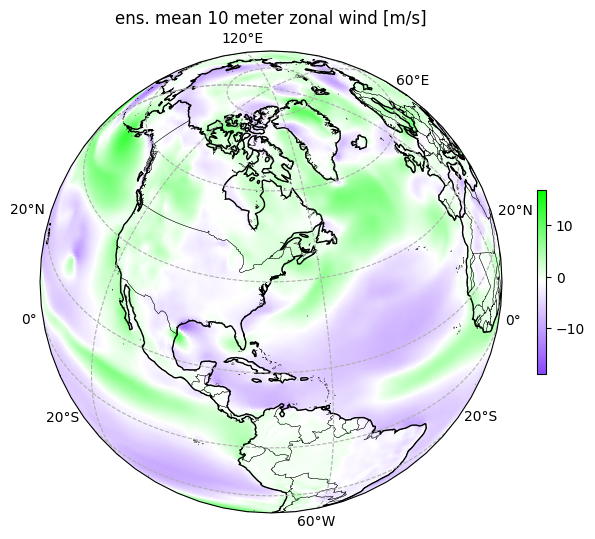

In [13]:
nyc_lat = 40
nyc_lon = 360 - 74



def Nvidia_cmap():
    colors = ["#8946ff", "#ffffff", "#00ff00"]
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors)
    return cmap


plt.close("all")

data = ds.u10m[0, 10,:,:]  # [ensemble, time, lat, lon]
# data = ds.u925[0, 10,:,:]  # [ensemble, time, lat, lon]

fig = plt.figure(figsize=(9, 6))
plt.rcParams["figure.dpi"] = 100
proj = ccrs.NearsidePerspective(central_longitude=nyc_lon, central_latitude=nyc_lat)

ax = fig.add_subplot(111, projection=proj)
ax.set_title("ens. mean 10 meter zonal wind [m/s]")
img = ax.pcolormesh(
    ds.lon,
    ds.lat,
    data,
    transform=ccrs.PlateCarree(),
    cmap=Nvidia_cmap(),
    # vmin=-20,
    # vmax=20,
)
ax.coastlines(linewidth=1)
ax.add_feature(countries, edgecolor="black", linewidth=0.25)
plt.colorbar(img, ax=ax, shrink=0.40, norm=mcolors.CenteredNorm(vcenter=0))
gl = ax.gridlines(draw_labels=True, linestyle="--")
plt.savefig(f"{output_path}/gloabl_mean_zonal_wind_contour.png")